<a href="https://colab.research.google.com/github/Animesh-Guchhait/Time-Series/blob/main/time_series.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TSLA stock prise prediction using ARMA and GARCH

In this assignment, stock prise data will be predicted using ARMA and GARCH models and their performence will be measured.

Two procedures will be preformed:

At very first, cleaning and processing will be performed on the data and log return column will be generated from stock price.Then we will split the data as train data and test data.Some descriptive ststistics will be performed on the train data to know some statistical features of the data.Then stationarity of log return will be checked on train data. Generally log return data are stationary.In case it is not, we will go for further transformation.

After cleaning, processing and confirming the stationarity of the data, appropriate ARMA model will be fitted on it. Now we will get residual from that model on train data.Then we will perform the Ljung - Box test first on residual, and then on $residual^2$. If the null hypothesis is accepted for residual and is rejected for $residual^2$,we will go for further procedure.

1. Procedure 1:
Uaing above mentioned ARMA model,we will predict future returns and stock prises.Then appropriate GARCH model will be fitted to know future volatility of the returns and stock prises.Performance of the prediction will be measured on the stock prise using the test dataset.


2. Procedure 2:
We have already fitted ARMA model and have got residual from that model on train data. We will fit appropriate ARMA model on $residual^2$ and will predict future $residual^2$.We know that $\epsilon_t=\sigma_t a_t$, where $a_t$ comes from N(0,1). So, Now future $residual_t=sign(a_t)\sqrt(residual_t^2)$. Our new modified predicted retrun $r_t^{modi}=r_t + residual_t$, where $r_t$ is predicted return from ARMA and from $r_t^{modi}$ we will get modified predicted price $y_t^{modi}$ also. So in this way we will get modified forcasts of stock prices.Performance of this procedure will be measured on test dataset.





Load some important libraries to use

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
import statsmodels.api as sm
import warnings
warnings.filterwarnings('ignore')

# Loading and Processing Data
* import the daily TSLA stock data( collected from Yahoo finance [here](https://finance.yahoo.com/quote/TSLA/history?period1=1483228800&period2=1638057600&interval=1d&filter=history&frequency=1d&includeAdjustedClose=true) )
* preparing the data for further analysis

In [ ]:
data=pd.read_csv('TSLA.csv')

In [ ]:
data

,Date,Open,High,Low,Close,Adj Close,Volume
0,2017-01-03,42.972000,44.066002,42.192001,43.397999,43.397999,29616500
1,2017-01-04,42.950001,45.599998,42.862000,45.397999,45.397999,56067500
2,2017-01-05,45.284000,45.495998,44.389999,45.349998,45.349998,29558500
3,2017-01-06,45.386002,46.062000,45.090000,45.801998,45.801998,27639500
4,2017-01-09,45.793999,46.383999,45.599998,46.256001,46.256001,19897500
...,...,...,...,...,...,...,...
1230,2021-11-19,1098.869995,1138.719971,1092.699951,1137.060059,1137.060059,21168000
1231,2021-11-22,1162.329956,1201.949951,1132.430054,1156.869995,1156.869995,33072500
1232,2021-11-23,1167.510010,1180.500000,1062.699951,1109.030029,1109.030029,36171700
1233,2021-11-24,1080.390015,1132.770020,1062.000000,1116.000000,1116.000000,22560200


This TSLA daily stock price data has 1235 days data and it has open, high,low, close, Adj close prices for the stock. We will consider only 'close price' for our study.

In [ ]:
data=data[['Date','Close']]

In [ ]:
data.rename(columns={'Close':'Price'},inplace=True)

In [ ]:
data['Date']=pd.to_datetime(data['Date'], infer_datetime_format='%d-%m-%y')

In [ ]:
data.head(5)

,Date,Price
0,2017-01-03,43.397999
1,2017-01-04,45.397999
2,2017-01-05,45.349998
3,2017-01-06,45.801998
4,2017-01-09,46.256001


Now this data set has only two column, Date and Price. Let see if this data has any missing value or not.

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1235 entries, 0 to 1234
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    1235 non-null   datetime64[ns]
 1   Price   1235 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 19.4 KB


From the above information,we can see that dataset has no missing values, So no need of interpolation.Now we will create the rate column for log rate of return using the formula $ln(\frac {price(i)}{price(i-1)})$

In [ ]:
import math
data['rate']=0
for i in range(1,len(data['rate'])):
    data.loc[i,'rate']=math.log(data.loc[i,'Price']/data.loc[i-1,'Price'])

In [ ]:
data=data.loc[1:]

In [ ]:
data.head(4) # Printing first 4 columns

,Date,Price,rate
1,2017-01-04,45.397999,0.045055
2,2017-01-05,45.349998,-0.001058
3,2017-01-06,45.801998,0.009918
4,2017-01-09,46.256001,0.009863


Now we have Date , Price and rate as columns in our data set

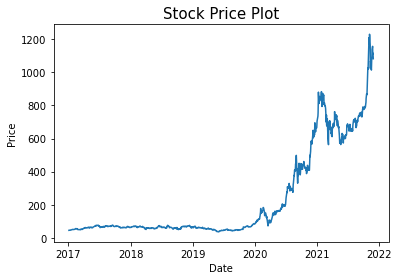

In [ ]:
plt.plot(data['Date'],data['Price'])
plt.xlabel('Date')
plt.ylabel('Price')
plt.title("Stock Price Plot",fontsize=15)
plt.show()

Now we will split the data Set into train and test data.Test data will contain last 7 observations and train data will contain rest.

In [ ]:
data_test=data.loc[1228:]
data1=data.loc[:1227] # data1 is for train data

In [ ]:
data_test

,Date,Price,rate
1228,2021-11-17,1089.010010,0.031984
1229,2021-11-18,1096.380005,0.006745
1230,2021-11-19,1137.060059,0.036432
1231,2021-11-22,1156.869995,0.017272
1232,2021-11-23,1109.030029,-0.042232
1233,2021-11-24,1116.000000,0.006265
1234,2021-11-26,1081.920044,-0.031014


now data1 is our train data and data_test is test data which is showed above.

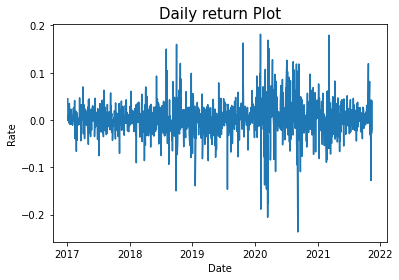

In [ ]:
plt.plot(data1['Date'],data1['rate'])
plt.xlabel('Date')
plt.ylabel('Rate')
plt.title("Daily return Plot",fontsize=15)
plt.show()

Now some descriptive statistics of our train data is shown below.

In [ ]:
data1['rate'].describe()

count    1227.000000
mean        0.002600
std         0.037958
min        -0.236518
25%        -0.014837
50%         0.001661
75%         0.019577
max         0.181445
Name: rate, dtype: float64

In [ ]:
kurt = data1['rate'].kurt()
kurt

5.5442800886827825

In [ ]:
skew = data1['rate'].skew()
skew

-0.13582013604792614

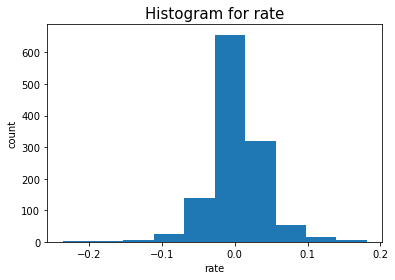

In [ ]:
plt.hist(data1['rate'])
plt.xlabel('rate')
plt.ylabel('count')
plt.title("Histogram for rate",fontsize=15)
plt.show()

# STEP2
* Checking stationarity of data
    using
    1. ADF test
    2. KPSS test
    3. PP test

In [ ]:
from statsmodels.tsa.stattools import adfuller, kpss

In [ ]:
# 1. ADF Test
result = adfuller(data1.rate.values, autolag='AIC')
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')
for key, value in result[4].items():
    print('Critial Values:')
    print(f'   {key}, {value}')

ADF Statistic: -18.727302081683586
p-value: 2.031497235719926e-30
Critial Values:
   1%, -3.4357038129673962
Critial Values:
   5%, -2.8639042041471887
Critial Values:
   10%, -2.5680287376916997


In [ ]:
# 2. KPSS Test
result = kpss(data1.rate.values, regression='c')
print('\nKPSS Statistic: %f' % result[0])
print('p-value: %f' % result[1])
for key, value in result[3].items():
    print('Critial Values:')
    print(f'   {key}, {value}')


KPSS Statistic: 0.334995
p-value: 0.100000
Critial Values:
   10%, 0.347
Critial Values:
   5%, 0.463
Critial Values:
   2.5%, 0.574
Critial Values:
   1%, 0.739


In [ ]:
# 3. PP test
#!pip install arch
import arch.unitroot as at
pp=at.PhillipsPerron(data['rate'])
print("stat : {0:0.4f}".format(pp.stat))
print("pvalue :{0:0.4f}".format(pp.pvalue))

stat : -35.6366
pvalue :0.0000


The data1['rate'], train dataset is stationary, it is clear from above tests ADF test, KPSS test and PP test.

# ARMA model
Find appropriate p and q 

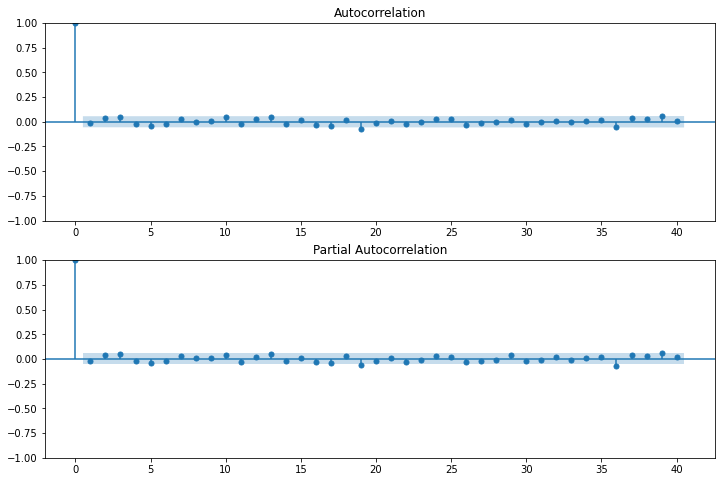

In [ ]:

fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(data1['rate'],lags=40,ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(data1['rate'],lags=40,ax=ax2)

From above Autocorrelation and partial autocorrelation plot, we can guess that p=q=0. lets check AIC and BIC of some models with diffrent values of p and q.

In [ ]:
from pmdarima.arima import auto_arima
from statsmodels.tsa.arima.model import ARIMA

In [ ]:
for i in range(4):
    for j in range(4):
        model=ARIMA(data1['rate'],order=(i,0,j))
        model=model.fit()
        print('p=',i,'q=',j,'  aic',round(model.aic,2), '  bic', round(model.bic,2))

p= 0 q= 0   aic -4542.64   bic -4532.41
p= 0 q= 1   aic -4540.9   bic -4525.57
p= 0 q= 2   aic -4541.36   bic -4520.91
p= 0 q= 3   aic -4542.99   bic -4517.43
p= 1 q= 0   aic -4540.94   bic -4525.6
p= 1 q= 1   aic -4538.97   bic -4518.52
p= 1 q= 2   aic -4540.69   bic -4515.13
p= 1 q= 3   aic -4541.25   bic -4510.58
p= 2 q= 0   aic -4541.08   bic -4520.63
p= 2 q= 1   aic -4539.13   bic -4513.56
p= 2 q= 2   aic -4544.53   bic -4513.86
p= 2 q= 3   aic -4542.56   bic -4506.77
p= 3 q= 0   aic -4542.28   bic -4516.72
p= 3 q= 1   aic -4540.26   bic -4509.58
p= 3 q= 2   aic -4541.57   bic -4505.78
p= 3 q= 3   aic -4540.64   bic -4499.74


From above AIC and BIC list, we can say that p=q=0 will fit better.

# Using p=q=0

In [ ]:
# p=0,q=0

model=ARIMA(data1['rate'],order=(0,0,0))
model_arima=model.fit()
print(model_arima.summary())

                               SARIMAX Results                                
Dep. Variable:                   rate   No. Observations:                 1227
Model:                          ARIMA   Log Likelihood                2273.318
Date:                Sun, 28 Nov 2021   AIC                          -4542.636
Time:                        21:19:55   BIC                          -4532.412
Sample:                             0   HQIC                         -4538.789
                               - 1227                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0026      0.001      2.394      0.017       0.000       0.005
sigma2         0.0014      3e-05     47.972      0.000       0.001       0.001
Ljung-Box (L1) (Q):                   0.30   Jarque-

In [ ]:
residuals = pd.DataFrame(model_arima.resid)

In [ ]:
residuals.columns=['residual']
residuals.index=data1.Date

In [ ]:
residuals

,residual
Date,
2017-01-04,0.042459
2017-01-05,-0.003653
2017-01-06,0.007322
2017-01-09,0.007268
2017-01-10,-0.008711
...,...
2021-11-10,0.039917
2021-11-11,-0.006761
2021-11-12,-0.031296


Above data set is residual data set for train data. We will perform Ljungbox test on residual and $residual^2$ datasets.

# Ljungbox test

In [ ]:
sm.stats.acorr_ljungbox(model_arima.resid, lags=[5], return_df=True)

,lb_stat,lb_pvalue
5,7.973162,0.157721


In [ ]:
sm.stats.acorr_ljungbox(model_arima.resid**2, lags=[5], return_df=True)

,lb_stat,lb_pvalue
5,153.604389,2.280915e-31


Appling Ljungbox test on residual and $residual^2$ , we saw that null hypothesis is accepted for residual and is not accepted for $residual^2$. So we can perform further procedure 

# Procedure 1.

# GARCH model
Now we will try to find appropriate GARCH model to get volatility

In [ ]:
from arch import arch_model

In [ ]:
def aic_bic(data=data1['rate'],p_range=4,q_range=4):
    d=pd.DataFrame({'p':[],'q':[],'aic':[],'bic':[]})
    for i in range(1,p_range):
        for j in range(1,q_range):
            model=arch_model(data, p=i, q=j)
            model=model.fit()
            new={'p':i,'q':j,'aic': round(model.aic,2),'bic':round(model.bic,2)}
            d=d.append(new,ignore_index=True)
    return(d)

In [ ]:
d=aic_bic()

Iteration:      1,   Func. Count:      6,   Neg. LLF: 78684611.69536704
Iteration:      2,   Func. Count:     17,   Neg. LLF: 30755845.056136947
Iteration:      3,   Func. Count:     28,   Neg. LLF: 1604585948992.2974
Iteration:      4,   Func. Count:     38,   Neg. LLF: 10440.232059763566
Iteration:      5,   Func. Count:     47,   Neg. LLF: -2384.1538027621687
Optimization terminated successfully    (Exit mode 0)
            Current function value: -2384.153803909521
            Iterations: 9
            Function evaluations: 47
            Gradient evaluations: 5
Iteration:      1,   Func. Count:      7,   Neg. LLF: 14672485.309376791
Iteration:      2,   Func. Count:     19,   Neg. LLF: 217477.41609222078
Iteration:      3,   Func. Count:     31,   Neg. LLF: 792817358554862.0
Iteration:      4,   Func. Count:     43,   Neg. LLF: 1224679.471754722
Iteration:      5,   Func. Count:     55,   Neg. LLF: -2382.657596265878
Optimization terminated successfully    (Exit mode 0)
          

In [ ]:
d

,p,q,aic,bic
0,1.0,1.0,-4760.31,-4739.86
1,1.0,2.0,-4755.32,-4729.75
2,1.0,3.0,-4748.49,-4717.81
3,2.0,1.0,-4758.87,-4733.30
4,2.0,2.0,-4749.95,-4719.27
5,2.0,3.0,-4760.97,-4725.18
6,3.0,1.0,-4756.87,-4726.19
7,3.0,2.0,-4740.81,-4705.02
8,3.0,3.0,-4758.97,-4718.07


Above table shows aic and bic for diffrent p and q used in GARCH model, from the table we can conclude that 'p=2, q=1' can be a good fit for GARCH.

In [ ]:
model=arch_model(data1['rate'], p=2, q=1)
model=model.fit()

Iteration:      1,   Func. Count:      7,   Neg. LLF: 7453595.964026013
Iteration:      2,   Func. Count:     19,   Neg. LLF: 234683.2074855288
Iteration:      3,   Func. Count:     31,   Neg. LLF: 7111.856686511826
Iteration:      4,   Func. Count:     40,   Neg. LLF: 16773995.174984517
Iteration:      5,   Func. Count:     52,   Neg. LLF: 2496.1851903734428
Iteration:      6,   Func. Count:     63,   Neg. LLF: -58.88671748791687
Iteration:      7,   Func. Count:     72,   Neg. LLF: -1172.041443366312
Iteration:      8,   Func. Count:     80,   Neg. LLF: -1882.2867659024037
Iteration:      9,   Func. Count:     89,   Neg. LLF: -2156.1688762161516
Iteration:     10,   Func. Count:     97,   Neg. LLF: -1849.6770568290704
Iteration:     11,   Func. Count:    104,   Neg. LLF: -2296.028229077373
Iteration:     12,   Func. Count:    111,   Neg. LLF: -2383.7915231863194
Iteration:     13,   Func. Count:    117,   Neg. LLF: -2384.3168161645217
Iteration:     14,   Func. Count:    123,   Neg. 

In [ ]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:                   rate   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:                2384.43
Distribution:                  Normal   AIC:                          -4758.87
Method:            Maximum Likelihood   BIC:                          -4733.30
                                        No. Observations:                 1227
Date:                Sun, Nov 28 2021   Df Residuals:                     1226
Time:                        21:06:37   Df Model:                            1
                                 Mean Model                                 
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu         2.2212e-03  9.611e-04      2.311  2.082e-02 [3.375e-04,4.105e-03]
                               Volatility Model                              
=============================================================================
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
omega      3.6966e-05  7.427e-06      4.977  6.454e-07  [2.241e-05,5.152e-05]
alpha[1]       0.0612  2.772e-02      2.208  2.725e-02    [6.872e-03,  0.116]
alpha[2]   4.2465e-19  3.469e-02  1.224e-17      1.000 [-6.799e-02,6.799e-02]
beta[1]        0.9131  2.485e-02     36.741 1.589e-295      [  0.864,  0.962]
=============================================================================

Covariance estimator: robust
"""

In the above model, GARCH(2,1) model is fitted.From the above summary,we can see that alpha[2] is not significant in this model. So we will try GARCH(1,1) model now.

In [ ]:
model=arch_model(data1['rate'], p=1, q=1)
model_garch=model.fit()

Iteration:      1,   Func. Count:      6,   Neg. LLF: 78684611.69536704
Iteration:      2,   Func. Count:     17,   Neg. LLF: 30755845.056136947
Iteration:      3,   Func. Count:     28,   Neg. LLF: 1604585948992.2974
Iteration:      4,   Func. Count:     38,   Neg. LLF: 10440.232059763566
Iteration:      5,   Func. Count:     47,   Neg. LLF: -2384.1538027621687
Optimization terminated successfully    (Exit mode 0)
            Current function value: -2384.153803909521
            Iterations: 9
            Function evaluations: 47
            Gradient evaluations: 5


In [ ]:
model_garch.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:                   rate   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:                2384.15
Distribution:                  Normal   AIC:                          -4760.31
Method:            Maximum Likelihood   BIC:                          -4739.86
                                        No. Observations:                 1227
Date:                Sun, Nov 28 2021   Df Residuals:                     1226
Time:                        21:20:25   Df Model:                            1
                                 Mean Model                                 
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu         2.1916e-03  9.466e-04      2.315  2.060e-02 [3.363e-04,4.047e-03]
                              Volatility Model                              
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega      2.8820e-05  3.799e-06      7.587  3.269e-14 [2.138e-05,3.627e-05]
alpha[1]       0.0500  1.587e-02      3.152  1.624e-03 [1.890e-02,8.109e-02]
beta[1]        0.9300  1.537e-02     60.496      0.000     [  0.900,  0.960]
============================================================================

Covariance estimator: robust
"""

Above model is GARCH(1,1) and from the above summary we can see that each coefficents are significants.So, Next we will predict future volatility of the data for next 7 days.

In [ ]:
prediction = model_garch.forecast(horizon=7)
future_dates = data_test.Date
prediction = pd.Series(np.sqrt(prediction.variance.values[-1,:]), index=future_dates)

Text(0.5, 1.0, 'Volatility Prediction - Next 7 Days')

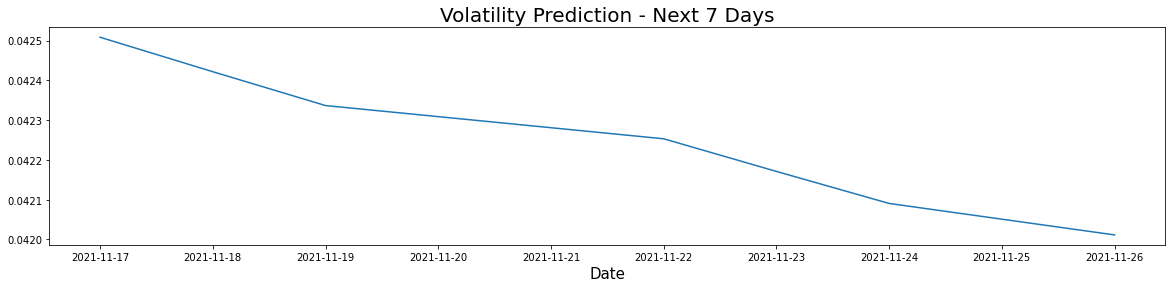

In [ ]:
plt.figure(figsize=(20,4))
prediction1=prediction.copy()
prediction1.index=data_test.index
plt.plot(prediction1)
plt.xlabel('Date',fontsize=15)
plt.title('Volatility Prediction - Next 7 Days', fontsize=20)

We have got above plotted curve on future volatility.Now we will plot estimated stock prise(comes from ARMA model) with volatility and true price(collected from test data set) for 7 days.

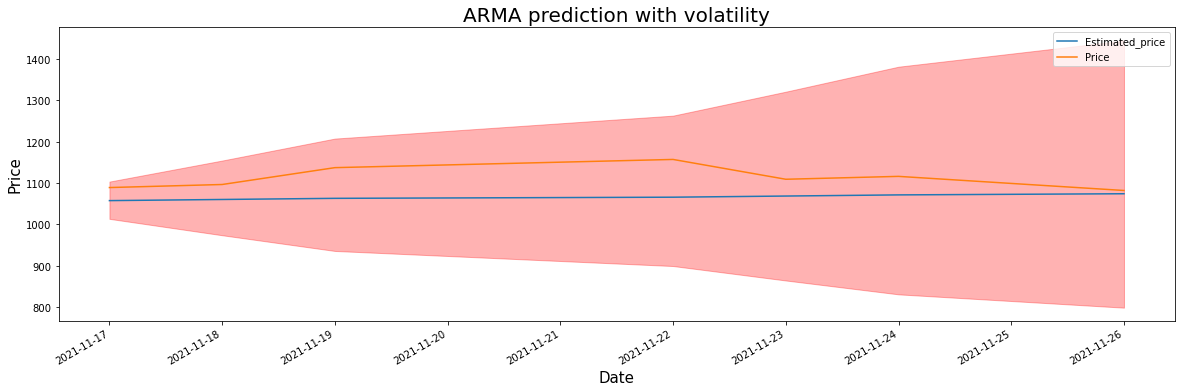

In [ ]:
start=len(data1)
end=len(data1)+len(data_test)-1
pred=model_arima.predict(start=start,end=end,typ='levels').rename('ARIMA Predictions')
pred=pd.DataFrame(pred)
prediction.index=pred.index
pred['vol-']=pred['ARIMA Predictions']-prediction
pred['vol+']=pred['ARIMA Predictions']+prediction

l=[]
l1=[]
l2=[]
j=list(pred.index)[0]
for i in pred.index:
    if i ==j:
        l.append(math.exp(pred.loc[i]['ARIMA Predictions'])*data.loc[i-1]['Price'])
        l1.append(math.exp(pred.loc[i]['vol-'])*data.loc[i-1]['Price'])
        l2.append(math.exp(pred.loc[i]['vol+'])*data.loc[i-1]['Price'])
    else:
        l.append(math.exp(pred.loc[i]['ARIMA Predictions'])*l[-1])
        l1.append(math.exp(pred.loc[i]['vol-'])*l1[-1])
        l2.append(math.exp(pred.loc[i]['vol+'])*l2[-1])
pred['Estimated_price']=l
pred['Estimated_price_vol+']=l2
pred['Estimated_price_vol-']=l1
data_test.index=data_test['Date']
pred.index=data_test['Date']
plt.figure(figsize=(20,6))
pred['Estimated_price'].plot(legend=True)
data_test['Price'].plot(legend=True)

plt.fill_between(pred.index, pred['Estimated_price_vol-'],
                 pred['Estimated_price_vol+'], color='red', alpha=.3)
plt.title('ARMA prediction with volatility',fontsize=20)
plt.xlabel('Date',fontsize=15)
plt.ylabel('Price',fontsize=15)
plt.show()

In [ ]:
print('RMSE on test data is :',
    round(math.sqrt((abs(pred['Estimated_price']
                    -data_test['Price'])**2).sum()/len(l)),4))

RMSE on test data is : 53.1841


RMSE of this model on test data set is 53.18

# Procedure 2
Here we will first fit appropriate ARMA model on $residual^2$,from which we will predict residuals and modified return and price.


In [ ]:
residuals = pd.DataFrame(model_arima.resid)

In [ ]:
sq_residuals=residuals**2

Now to test stationarity of $residual^2$

In [ ]:
result = adfuller(sq_residuals, autolag='AIC')
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')
for key, value in result[4].items():
    print('Critial Values:')
    print(f'   {key}, {value}')

ADF Statistic: -5.431896600094837
p-value: 2.9020411653651322e-06
Critial Values:
   1%, -3.43577938005948
Critial Values:
   5%, -2.863937543790164
Critial Values:
   10%, -2.568046493171221


In [ ]:
pp=at.PhillipsPerron(sq_residuals)
print("stat : {0:0.4f}".format(pp.stat))
print("pvalue :{0:0.4f}".format(pp.pvalue))

stat : -34.6765
pvalue :0.0000


From the above PP and ADF test,we can see that $residual^2$ is stationary.Now we will try to find appropriate p and q to fit ARMA on $residual^2$.

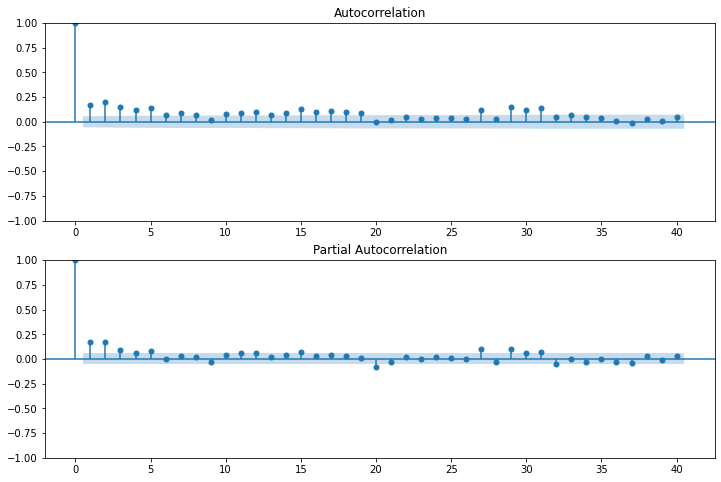

In [ ]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(sq_residuals,lags=40,ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(sq_residuals,lags=40,ax=ax2)

From auto correlation and partial autocorrelation plot, we can guess that p and q will be around 2.So, we will check AIC and BIC for few models with diffrent p and q in between 0 and 3

In [ ]:
for i in range(4):
    for j in range(4):
        model=ARIMA(sq_residuals[0],order=(i,0,j))
        model=model.fit()
        print('p=',i,'q=',j,'  aic',round(model.aic,2), '  bic', round(model.bic,2))

p= 0 q= 0   aic -10096.32   bic -10086.09
p= 0 q= 1   aic -10122.51   bic -10107.17
p= 0 q= 2   aic -10151.32   bic -10130.87
p= 0 q= 3   aic -10159.81   bic -10134.25
p= 1 q= 0   aic -10132.12   bic -10116.78
p= 1 q= 1   aic -10189.72   bic -10169.28
p= 1 q= 2   aic -10186.59   bic -10161.03
p= 1 q= 3   aic -10184.1   bic -10153.43
p= 2 q= 0   aic -10166.58   bic -10146.13
p= 2 q= 1   aic -10184.96   bic -10159.39
p= 2 q= 2   aic -10185.62   bic -10154.95
p= 2 q= 3   aic -10182.2   bic -10146.42
p= 3 q= 0   aic -10175.56   bic -10150.0
p= 3 q= 1   aic -10172.96   bic -10142.28
p= 3 q= 2   aic -9688.12   bic -9652.34
p= 3 q= 3   aic -10184.53   bic -10143.63


From above AIC and BIC table,we can find out that p=q=1 can be a good option to go.

In [ ]:
model_resu=ARIMA(sq_residuals[0],order=(1,0,1))
model_resu=model_resu.fit()
print(model_resu.summary())
start=len(data1)
end=len(data1)+len(data_test)-1
pred=model_resu.predict(start=start,end=end,typ='levels').rename('Square_Residual')
Sq_resu_pred=pd.DataFrame(pred)


                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1227
Model:                 ARIMA(1, 0, 1)   Log Likelihood                5098.862
Date:                Sun, 28 Nov 2021   AIC                         -10189.725
Time:                        18:41:17   BIC                         -10169.276
Sample:                             0   HQIC                        -10182.030
                               - 1227                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0014      0.000      2.953      0.003       0.000       0.002
ar.L1          0.9110      0.018     49.655      0.000       0.875       0.947
ma.L1         -0.7828      0.025    -31.726      0.0

Each coefficients are significant for this model.Now we will predict next 7 days $residual^2$ and will calculate next 7 days $residual$ by below mentioned formula
$$residual_t=sign(a_t)\sqrt(residual_t^2)$$ where $a_t$ comes from N(0,1)

In [ ]:
from random import gauss
series=[]
for i in range(len(Sq_resu_pred)):
    x=gauss(0,1/2)
    x=x/abs(x)
    series.append(x)


In [ ]:
resu_pred=Sq_resu_pred**.5

In [ ]:
series=pd.DataFrame(series)

In [ ]:
residual=pd.DataFrame(resu_pred.values*series.values, columns=resu_pred.columns, index=resu_pred.index)

In [ ]:
residuals=residual.copy()
residuals.columns=['Residual']
residuals.index=data_test.index

In [ ]:
residuals

,Residual
Date,
2021-11-17,0.042801
2021-11-18,0.042390
2021-11-19,-0.042012
2021-11-22,0.041665
2021-11-23,-0.041346
2021-11-24,-0.041053
2021-11-26,0.040785


Above data set shows predicted residuals for next 7 days.Our new modified predicted retrun $r_t^{modi}=r_t + residual_t$, where $r_t$ is predicted return from ARMA and from $r_t^{modi}$ we will get modified predicted price $y_t^{modi}$ also.

Now we will plot predicted modified prices with true prices below 

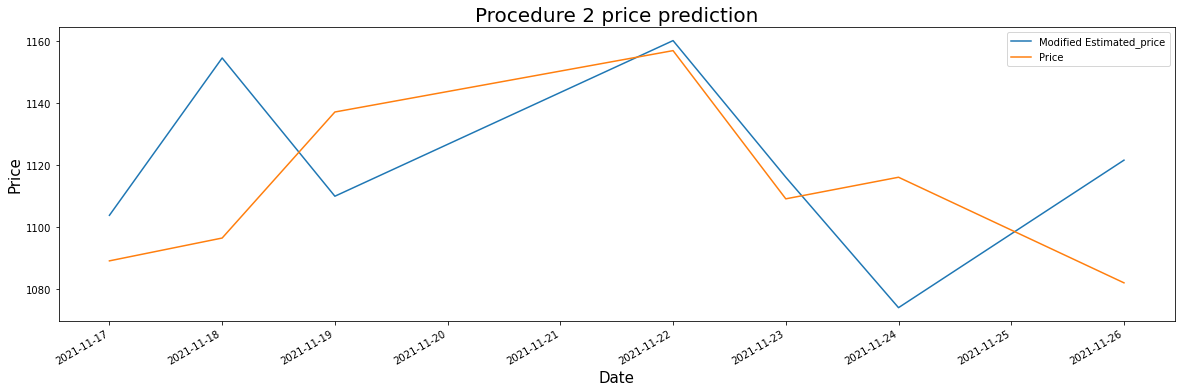

In [ ]:
pred=model_arima.predict(start=start,end=end,typ='levels').rename('ARIMA Predictions')
l=[]
pred=pd.DataFrame(pred)
residual.index=pred.index
pred['modiARIMA']=pred['ARIMA Predictions']+residual['Square_Residual']
j=list(pred.index)[0]
for i in pred.index:
    if i ==j:
        l.append(math.exp(pred.loc[i]['modiARIMA'])*data.loc[i-1]['Price'])
    else:
        l.append(math.exp(pred.loc[i]['modiARIMA'])*l[-1])
pred['Modified Estimated_price']=l
data_test.index=data_test['Date']
plt.figure(figsize=(20,6))
pred.index=data_test['Date']
pred['Modified Estimated_price'].plot(legend=True)
data_test['Price'].plot(legend=True)
plt.xlabel('Date',fontsize=15)
plt.ylabel('Price',fontsize=15)
plt.title('Procedure 2 price prediction',fontsize=20)
plt.show()

In [ ]:
print('RMSE on test data is :',
    round(math.sqrt((abs(pred['Modified Estimated Price']
                    -data_test['Price'])**2).sum()/len(l)),4))

RMSE on test data is : 33.2348


RMSE for the procedure 2 is 33.23 on test data

# Predictions of Stock Prices using both Procedures

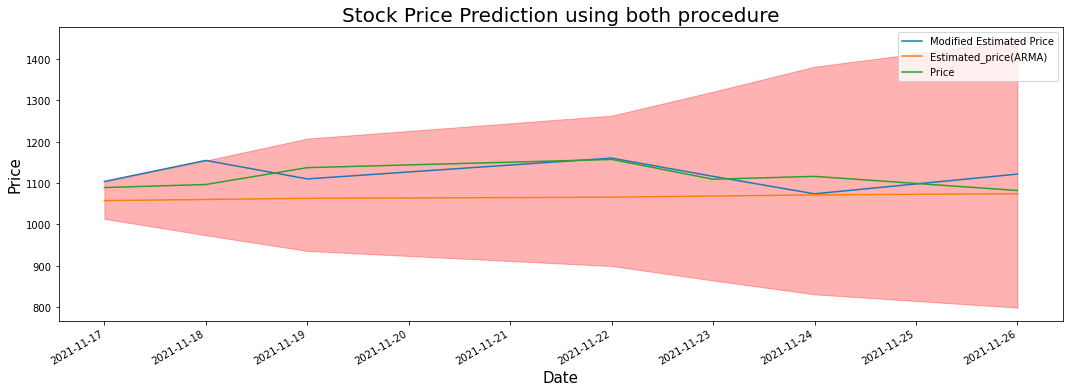

In [ ]:
pred=model_arima.predict(start=start,end=end,typ='levels').rename('ARIMA Predictions')
pred=pd.DataFrame(pred)
prediction.index=pred.index
pred['vol-']=pred['ARIMA Predictions']-prediction
pred['vol+']=pred['ARIMA Predictions']+prediction
pred['modiARIMA']=pred['ARIMA Predictions']+residual['Square_Residual']
l=[]
l1=[]
l2=[]
l3=[]
j=list(pred.index)[0]
for i in pred.index:
    if i ==j:
        l.append(math.exp(pred.loc[i]['ARIMA Predictions'])*data.loc[i-1]['Price'])
        l1.append(math.exp(pred.loc[i]['vol-'])*data.loc[i-1]['Price'])
        l2.append(math.exp(pred.loc[i]['vol+'])*data.loc[i-1]['Price'])
        l3.append(math.exp(pred.loc[i]['modiARIMA'])*data.loc[i-1]['Price'])
    else:
        l.append(math.exp(pred.loc[i]['ARIMA Predictions'])*l[-1])
        l1.append(math.exp(pred.loc[i]['vol-'])*l1[-1])
        l2.append(math.exp(pred.loc[i]['vol+'])*l2[-1])
        l3.append(math.exp(pred.loc[i]['modiARIMA'])*l3[-1])
pred['Estimated_price(ARMA)']=l
pred['Estimated_price_vol+']=l2
pred['Estimated_price_vol-']=l1
pred['Modified Estimated Price']=l3
data_test.index=data_test['Date']
pred.index=data_test['Date']
plt.figure(figsize=(18,6))
pred['Modified Estimated Price'].plot(legend=True)
pred['Estimated_price(ARMA)'].plot(legend=True)
data_test['Price'].plot(legend=True)

plt.fill_between(pred.index, pred['Estimated_price_vol-'],
                 pred['Estimated_price_vol+'], color='red', alpha=.3)
plt.xlabel('Date',fontsize=15)
plt.ylabel('Price',fontsize=15)
plt.title('Stock Price Prediction using both procedure',fontsize=20)
plt.show()